# Bunched Up Bus Analysis Using MBTA Data

This project attempts to map the occurrence of 'bunch ups' buses, a condition where several buses, arrive immediately one after the other at a given bus stop.
<br /><br />
Bunched buses is an indication that the bus system is congested and thrashing, becoming less efficient as it attempts to handle more traffic. This is characterized by unusually large groups of people waiting long times during rush hours. When eventually a bus arrives it takes a unusually long time to load and may overflow. Ultimately a second nearly empty bus and sometimes a third bus will follow on immediately after the first bus, these latter buses being under utilized. This condition causes a breakdown in the efficiency of the bus line since buses are extremely on evenly loaded and large wait times occur between the sets of buses.
<br /><br />
Here we attempt to characterize the system breakdown by looking at actual wait times for a first second and third bus from the standpoint of a single bus stop looking at buses traveling along each individual route over a one day
<br /><br />
The analysis utilizes Boston MBTA data accessible at 
http://mbta-history.apptic.xyz and 
https://www.mbta.com/gtfs_archive/ data repositories.

In [0]:
# initialize libraries 
from datetime import datetime, timedelta
from io import BytesIO, TextIOWrapper
import tarfile
from urllib.error import HTTPError
from urllib.request import urlopen

import numpy as np
import pandas as pd



## get_updates

Import data from the first repository and unzip it this contains time series of buses traveling across the system. From this data we obtain time specific vehicles transit each busstop.

In [0]:

def get_updates(dt):
    """Retrieves the vehicle updates for the given date from
    the archive site and read them into a pandas DataFrame.
    
    :param dt: a date-like object
    """
    # This reads the gzipped tarfile into memory, extracts the file,
    # and reads it directly into a dataframe.
    
    # Pandas can also read directly from URLs and file paths
    url = dt.strftime("http://mbta-history.apptic.xyz/%Y/%m/%Y-%m-%d.csv.gz")

    return pd.read_csv(url, dtype="unicode")

In [6]:
# timestamp is arbitrary and ought to be turned into a variable. Better yet 
# multiple days ought to be iterated over and the below material turned 
# into a method
dt = datetime(2018, 1, 9)
df = get_updates(dt)
df.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon
0,35793582,2018-01-09,343,9,y1891,INCOMING_AT,2018-01-09 08:28:57,42.29109191894531,-71.06278228759766
1,35793583,2018-01-09,381,16,y1881,INCOMING_AT,2018-01-09 08:29:26,42.29609298706055,-71.08749389648438
2,3658_1515485700_0,2018-01-09,70106,0,10094,INCOMING_AT,2018-01-09 08:22:14,42.340999603271484,-71.16741943359375
3,0,2018-01-09,NaN,0,172,IN_TRANSIT_TO,2018-01-09 08:22:06,42.3387451171875,-71.04429626464844
4,1,2018-01-09,NaN,0,252,IN_TRANSIT_TO,2018-01-09 08:28:04,42.33885955810547,-71.04425048828125


In [7]:
# just for fun to see what were working with
df["trip_id"].describe()


count     2414535
unique      17420
top             0
freq         5526
Name: trip_id, dtype: object

In [8]:
# we are only iterested in busis at stopes mask out all other data
mask = df["status"] == "STOPPED_AT"
stops_df =df[mask]
stops_df.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon
10,35793582,2018-01-09,343,9,y1891,STOPPED_AT,2018-01-09 08:29:57,42.296844482421875,-71.0611343383789
15,35793582,2018-01-09,343,9,y1891,STOPPED_AT,2018-01-09 08:29:57,42.296844482421875,-71.0611343383789
20,35793582,2018-01-09,343,9,y1891,STOPPED_AT,2018-01-09 08:29:57,42.296844482421875,-71.0611343383789
21,35793583,2018-01-09,382,17,y1881,STOPPED_AT,2018-01-09 08:30:27,42.30098342895508,-71.08590698242188
25,35793582,2018-01-09,343,9,y1891,STOPPED_AT,2018-01-09 08:29:57,42.296844482421875,-71.0611343383789


In [9]:
#convert stop_sequencet to int rename stop_sequence and remove unused colums
stops_df.loc[:,'stop_sequence_int'] = stops_df['stop_sequence'].astype(int)
stops_df["stop_sequence"] = stops_df["stop_sequence_int"]
stops_df = stops_df.drop("stop_sequence_int", 1, errors='ignore')
stops_df = stops_df.drop("lat", 1, errors='ignore')
stops_df = stops_df.drop("lon", 1, errors='ignore')
stops_df = stops_df.drop_duplicates()
stops_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp
10,35793582,2018-01-09,343,9,y1891,STOPPED_AT,2018-01-09 08:29:57
21,35793583,2018-01-09,382,17,y1881,STOPPED_AT,2018-01-09 08:30:27
51,35793582,2018-01-09,322,11,y1891,STOPPED_AT,2018-01-09 08:31:57
56,35793582,2018-01-09,322,11,y1891,STOPPED_AT,2018-01-09 08:32:13
57,35793583,2018-01-09,385,20,y1881,STOPPED_AT,2018-01-09 08:32:20


now we need to open up the base data set and find the table that associates route_id with trip_id which turns out to be located in the trips.txt file. We will join this to the previous data set we've been working with.

In [0]:
#import mbta data and unzip csv
import zipfile

def mbta_feed_urls():
    """Returns a generator of (feed_start_date, feed_end_date, archive_url)
    tuples from the MBTA's archived feeds site.
    """
    u = urlopen("https://www.mbta.com/gtfs_archive/archived_feeds.txt")
    for l in csv.DictReader(TextIOWrapper(BytesIO(u.read()))):
        yield (datetime.strptime(l["feed_start_date"], "%Y%m%d"),
               datetime.strptime(l["feed_end_date"], "%Y%m%d"),
               l["archive_url"])

def mbta_feed_urls_for(range_start=None, range_end=None):
    eastern = pytz.timezone("US/Eastern")
    range_start = range_start or datetime.now()
    range_end = range_end or range_start
    for start, end, url in mbta_feed_urls():
        if range_start.tzinfo:
            start = start.astimezone(eastern)
            end = end.astimezone(eastern)
        if start <= range_end:
            if end < range_start:
                continue
            yield url
            
def mbta_feed_url_for(when):
    """Get the URL for the MBTA's GTFS feed active at the 
    datetime `when`."""
    return next(mbta_feed_urls_for(when, when), None)

def get_zip(url="http://www.mbta.com/uploadedfiles/MBTA_GTFS.zip"):
    with urlopen(url) as u:
        return zipfile.ZipFile(BytesIO(u.read()))
    
def get_zip_item(feed, name):
    data = TextIOWrapper(BytesIO(feed.read(name + ".txt")), 
                         encoding="utf-8", line_buffering=True)
    # Specify 'unicode' as the datatype so that Pandas
    # doesn't try to infer cell types. It will get it
    # wrong anyway.
    return pd.read_csv(data, dtype="unicode")

Download the base zip file

In [0]:
# 2018, 3, 15
mbta_url = "https://cdn.mbta.com/archive/20180109.zip"
mbta_feed = get_zip(mbta_url)

unpack the needed stop_times.txt csv table 

In [12]:
stop_times = get_zip_item(mbta_feed, "stop_times")
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,timepoint,checkpoint_id
0,Logan-22-Weekday-trip,08:00:00,08:00:00,Logan-Subway,1,NaN,0,1,0,NaN
1,Logan-22-Weekday-trip,08:04:00,08:04:00,Logan-RentalCarCenter,2,NaN,0,0,0,NaN
2,Logan-22-Weekday-trip,08:09:00,08:09:00,Logan-A,3,NaN,0,0,0,NaN
3,Logan-22-Weekday-trip,08:12:00,08:12:00,Logan-B,4,NaN,0,0,0,NaN
4,Logan-22-Weekday-trip,08:17:00,08:17:00,Logan-Subway,5,NaN,1,0,0,NaN


Unpack the needed trips.txt csv table

In [13]:
# 1) get multi_route_trips table
route_to_trip = get_zip_item(mbta_feed, "trips")
route_to_trip.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,trip_route_type
0,Logan-22,Logan-Weekday,Logan-22-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN
1,Logan-22,Logan-Weekend,Logan-22-Weekend-trip,Loop,NaN,0,NaN,NaN,1,NaN
2,Logan-33,Logan-Weekday,Logan-33-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN
3,Logan-33,Logan-Weekend,Logan-33-Weekend-trip,Loop,NaN,0,NaN,NaN,1,NaN
4,Logan-55,Logan-Weekday,Logan-55-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN


Now join or in panda merge stops_df, route_to_trip, on=["trip_id"] this will allow us to look at records for a given busstop and given route.

In [14]:
##############################################################################################
# Join join >no trip_id=trip_id for stops_df, multi_route_trips < geting added_route_id

stop_times = pd.merge(stops_df, route_to_trip, on=["trip_id"])
stop_times.head(2)



,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,route_id,service_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,trip_route_type
0,35793582,2018-01-09,343,9,y1891,STOPPED_AT,2018-01-09 08:29:57,15,BUS12018-hbc18011-Weekday-02,Dudley via Fields Corner,NaN,1,C11-113,150082,1,NaN
1,35793582,2018-01-09,322,11,y1891,STOPPED_AT,2018-01-09 08:31:57,15,BUS12018-hbc18011-Weekday-02,Dudley via Fields Corner,NaN,1,C11-113,150082,1,NaN


Iit's now necessary to remove records of timestamps where a bus sits still at a given stop. Which buses do when they're on break war at the end of the line before they start moving on a new trip. We'd start by sorting in route stop vehicle order, then we remove duplicates.

In [15]:
# Build stops_sorted_df using sort function
stops_sort_df = stop_times.sort_values(['stop_id', 'route_id','vehicle_id',  'timestamp'])#,ascending=False

# fun test for our favorite bus route
# only ruot 70 in busis at stopes
# mask = stops_sort_df["route_id"] == "70"
# stops_sort_df[mask].head()

stops_sort_df.head(2)

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,route_id,service_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,trip_route_type
196445,35794607,2018-01-09,1,2,y1728,STOPPED_AT,2018-01-09 21:54:16,1,BUS12018-hbc18011-Weekday-02,Harvard,NaN,0,C01-19,010038,1,NaN
264650,35794582,2018-01-09,1,2,y1728,STOPPED_AT,2018-01-10 03:25:48,1,BUS12018-hbc18011-Weekday-02,Harvard,NaN,0,C01-25,010038,1,NaN


In [16]:
''' 
Build a col which determines if a bus has just arrived at a stop, 
opposed to having been waiting at a stop for multiple readings.
this is determined by looking at whether a bus stop remains the same and whether the bus has changed.
This is dependent on the data frame being in stop, bus sort order.
'''
stops_sort_df["new_stop"] = (stops_sort_df.vehicle_id != stops_sort_df.vehicle_id.shift()) \
  & (stops_sort_df.stop_id == stops_sort_df.stop_id.shift()) \
  & (stops_sort_df.route_id == stops_sort_df.route_id.shift())
# remove cluter
stops_sort_df = stops_sort_df.drop("service_id", 1, errors='ignore')
stops_sort_df = stops_sort_df.drop("trip_short_name", 1, errors='ignore')
stops_sort_df = stops_sort_df.drop("wheelchair_accessible", 1, errors='ignore')
stops_sort_df = stops_sort_df.drop("trip_route_type", 1, errors='ignore')
stops_sort_df = stops_sort_df.drop("shape_id", 1, errors='ignore')
stops_sort_df = stops_sort_df.drop("block_id", 1, errors='ignore')
stops_sort_df = stops_sort_df.drop("trip_headsign", 1, errors='ignore')
stops_sort_df.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,route_id,direction_id,new_stop
196445,35794607,2018-01-09,1,2,y1728,STOPPED_AT,2018-01-09 21:54:16,1,0,False
264650,35794582,2018-01-09,1,2,y1728,STOPPED_AT,2018-01-10 03:25:48,1,0,False
270022,35794545,2018-01-09,1,2,y1728,STOPPED_AT,2018-01-10 04:32:50,1,0,False
275653,35794551,2018-01-09,1,2,y1728,STOPPED_AT,2018-01-10 05:43:45,1,0,False
198002,35794562,2018-01-09,1,2,y1737,STOPPED_AT,2018-01-09 22:10:59,1,0,True


Now we simply remove cases where a bus has not moved using the test value new_stop

In [17]:
# mask out bad rows
# generate new bus_moves_sorted df with only record with them plus has moved from one stop to the next 
# still in busstop bus sort order
bus_moves_mask = stops_sort_df["new_stop"]
stops_sort_df =stops_sort_df[bus_moves_mask]
stops_sort_df.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,route_id,direction_id,new_stop
198002,35794562,2018-01-09,1,2,y1737,STOPPED_AT,2018-01-09 22:10:59,1,0,True
143357,35795176,2018-01-09,1,2,y1742,STOPPED_AT,2018-01-09 19:12:35,1,0,True
204182,35794589,2018-01-09,1,2,y1752,STOPPED_AT,2018-01-09 22:11:43,1,0,True
162901,35794588,2018-01-09,1,2,y1791,STOPPED_AT,2018-01-09 20:14:58,1,0,True
5576,35794736,2018-01-09,1,2,y1807,STOPPED_AT,2018-01-09 10:48:12,1,0,True


We need to now convert our time values which are in string format into actual datetime format for difference comparison and following steps.

In [0]:
from datetime import datetime
from pytz import timezone
import pytz
import time



def cnvt_ts_str2dt(ts_str):
  est = timezone('US/Eastern')
  utc = pytz.utc
  dt_format = "%Y-%m-%d %H:%M:%S"    
  dt_obj = datetime.strptime(ts_str, dt_format)    
  utc_dt = dt_obj.replace(tzinfo=utc)    
  return utc_dt.astimezone(est) #est.localize(datetime.strptime(ts_str, dt_format))




In [19]:
test_time ='2018-01-09 22:10:59'
test_ese = cnvt_ts_str2dt(test_time)
print(test_ese.strftime("%Y-%m-%d %H:%M:%S"))

2018-01-09 17:10:59


In [20]:
# build column with a real date time field type for using daytime functions
stop_dt_df = stops_sort_df["timestamp"].apply(cnvt_ts_str2dt)
stops_sort_df["stop_dt"] = stop_dt_df
#stops_sort_df = stops_sort_df.drop("timestamp", 1, errors='ignore')

stops_sort_df.head()
#print(stops_sort_df["stop_dt"].apply(type).head(1))

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,route_id,direction_id,new_stop,stop_dt
198002,35794562,2018-01-09,1,2,y1737,STOPPED_AT,2018-01-09 22:10:59,1,0,True,2018-01-09 17:10:59-05:00
143357,35795176,2018-01-09,1,2,y1742,STOPPED_AT,2018-01-09 19:12:35,1,0,True,2018-01-09 14:12:35-05:00
204182,35794589,2018-01-09,1,2,y1752,STOPPED_AT,2018-01-09 22:11:43,1,0,True,2018-01-09 17:11:43-05:00
162901,35794588,2018-01-09,1,2,y1791,STOPPED_AT,2018-01-09 20:14:58,1,0,True,2018-01-09 15:14:58-05:00
5576,35794736,2018-01-09,1,2,y1807,STOPPED_AT,2018-01-09 10:48:12,1,0,True,2018-01-09 05:48:12-05:00


This is a key step, we can now determine wait times at a given stop for buses on a specific route. This is available via the panda diff() function working on the stop_dt datetime col.

In [0]:
##############################################
#  waiting for next bus for a given route
##############################################
stops_sort_df = stops_sort_df.sort_values(['stop_id', 'route_id','stop_dt'])
stops_sort_df['bus1_wait'] = stops_sort_df.groupby(['stop_id', 'route_id'])['stop_dt'].diff(1)
stops_sort_df['bus2_wait'] = stops_sort_df.groupby(['stop_id', 'route_id'])['stop_dt'].diff(2)
stops_sort_df['bus3_wait'] = stops_sort_df.groupby(['stop_id', 'route_id'])['stop_dt'].diff(3)



In [0]:
# let us work with sec not datetime values for the 
stops_sort_df['wait1'] = stops_sort_df['bus1_wait'].dt.total_seconds()
stops_sort_df['wait2'] = stops_sort_df['bus2_wait'].dt.total_seconds()
stops_sort_df['wait3'] = stops_sort_df['bus3_wait'].dt.total_seconds()

In [0]:
# lets look at only route 70 temp test
# mask = stops_sort_df["route_id"] == "70"
# stops_sort_df = stops_sort_df[mask]
# stops_sort_df.head()


In [23]:
##################################################
# drop all rows with NaN wait time
stops_sort_df = stops_sort_df.dropna() # subset=['wait1', 'wait2', 'wait3']

stops_sort_df.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,route_id,direction_id,new_stop,stop_dt,bus1_wait,bus2_wait,bus3_wait,wait1,wait2,wait3
7346,35794662,2018-01-09,1,2,y1902,STOPPED_AT,2018-01-09 11:09:48,1,0,True,2018-01-09 06:09:48-05:00,00:21:36,00:35:41,01:12:26,1296.0,2141.0,4346.0
17516,35794690,2018-01-09,1,2,y1865,STOPPED_AT,2018-01-09 11:27:07,1,0,True,2018-01-09 06:27:07-05:00,00:17:19,00:38:55,00:53:00,1039.0,2335.0,3180.0
19034,35794654,2018-01-09,1,2,y1887,STOPPED_AT,2018-01-09 11:30:26,1,0,True,2018-01-09 06:30:26-05:00,00:03:19,00:20:38,00:42:14,199.0,1238.0,2534.0
24024,35794651,2018-01-09,1,2,y1880,STOPPED_AT,2018-01-09 11:45:27,1,0,True,2018-01-09 06:45:27-05:00,00:15:01,00:18:20,00:35:39,901.0,1100.0,2139.0
28246,35794649,2018-01-09,1,2,y1883,STOPPED_AT,2018-01-09 11:54:09,1,0,True,2018-01-09 06:54:09-05:00,00:08:42,00:23:43,00:27:02,522.0,1423.0,1622.0


In [24]:
stops_sort_df['x'] = stops_sort_df['wait1'].astype(int)
stops_sort_df['wait1'] = stops_sort_df['x']
stops_sort_df['x'] = stops_sort_df['wait2'].astype(int)
stops_sort_df['wait2'] = stops_sort_df['x']
stops_sort_df['x'] = stops_sort_df['wait3'].astype(int)
stops_sort_df['wait3'] = stops_sort_df['x']
stops_sort_df = stops_sort_df.drop("x", 1, errors='ignore')
pd.options.display.float_format = '{:,.0f}'.format
stats = stops_sort_df.describe()
stats

,stop_sequence,bus1_wait,bus2_wait,bus3_wait,wait1,wait2,wait3
count,"66,321",66321,66321,66321,"66,321","66,321","66,321"
mean,20,0 days 01:17:15.389394,0 days 02:28:27.735769,0 days 03:35:11.947603,"4,635","8,908","12,912"
std,20,0 days 01:31:14.356412,0 days 02:14:44.856477,0 days 02:48:34.750308,"5,474","8,085","10,115"
min,1,0 days 00:00:00,0 days 00:00:07,0 days 00:02:03,0,7,123
25%,8,0 days 00:20:51,0 days 00:52:19,0 days 01:28:05,"1,251","3,139","5,285"
50%,16,0 days 00:45:06,0 days 01:45:49,0 days 02:46:57,"2,706","6,349","10,017"
75%,26,0 days 01:38:01,0 days 03:20:09,0 days 04:57:58,"5,881","12,009","17,878"
max,210,0 days 16:02:49,0 days 18:30:36,0 days 19:27:38,"57,769","66,636","70,058"


In [25]:
# max time in huors

print('wait1 in huors', int(stats['wait1']['max']/60/60))


wait1 in huors 16


This extremely long maximum wait time is suspicious probably indicates miscounting from a previous day.
For this quickie analysis we will simply suspect large wait times as being artifacts and not attempt to correct this. Will look to exclude these long wait times from our analysis later on. 

TODO isolate the records with suspiciously large wait times and track their calculations looking for root error source.

In [26]:
stops_sort_df.query("wait2 < 50").tail(3)
#bus_moves_sorted.head()



,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,route_id,direction_id,new_stop,stop_dt,bus1_wait,bus2_wait,bus3_wait,wait1,wait2,wait3
6863,35895908,2018-01-09,875,25,y1635,STOPPED_AT,2018-01-09 10:58:45,32,1,True,2018-01-09 05:58:45-05:00,00:00:14,00:00:29,00:20:41,14,29,1241
50084,35794808,2018-01-09,926,12,y1791,STOPPED_AT,2018-01-09 13:02:29,66,1,True,2018-01-09 08:02:29-05:00,00:00:16,00:00:24,00:37:38,16,24,2258
80442,35605928,2018-01-09,989,31,y0491,STOPPED_AT,2018-01-09 14:47:54,57,0,True,2018-01-09 09:47:54-05:00,00:00:08,00:00:35,00:30:23,8,35,1823


Instead of working with raw times let's build bins and associate each reading what a bin so that we can place them into histograms, by counting how many busstop waiting events fall into each bin. 
Also we assume that there is some erroneous data at the low and high end of each rating scale.  Cutoffs are given which force data in the lower cut off region into the first bin wait times above  the upper cutoff into the last bin. We're doing this with an eye towards only looking at everything but the data in the last bin. Many of which have extremely high wait times. It's assumed the extremely high weight times are artifacts and not real.

In [27]:
########################################################
# qcut binarization of bus wait times
def cutoff_qcut(df, target, bin_lab, bins,
                low_cut, top_cut):
    """ 
    provides a qcut with a top and lower cutoff bins, all values
    below the lower cut off are in the first bin,
    all values above the top cut off or in the last been.
    Ben labels are integers the lower cut off bin will be 0 
    the top then be the number of bins variable + 1.
    """
    low_bin = 0
    top_bin = bins + 1
    mask1 =  (df > low_cut) & (df < top_cut)
    df[bin_lab], binsout = pd.qcut(df[mask1][target], bins, 
                                   labels=range(1,bins+1),
                                   duplicates='drop', retbins=True)
    df[bin_lab] = df[bin_lab].astype(int)
    df.loc[df[target] <= low_cut, bin_lab] = low_bin
    df.loc[df[target] >= top_cut, bin_lab] = top_bin
    print('bins',binsout)
    return df


###########################################

bins = 8
low_cut = 120
top_cut = 3600 # 1 houer  
stops_sort_df = cutoff_qcut(stops_sort_df, 'wait1', 'wait_bin1', 7, 30, top_cut)
stops_sort_df = cutoff_qcut(stops_sort_df, 'wait2', 'wait_bin2', 7, 60, top_cut)
stops_sort_df = cutoff_qcut(stops_sort_df, 'wait3', 'wait_bin3', 7, 60, top_cut)



bins [  31.  462.  890. 1309. 1731. 2199. 2811. 3599.]
bins [  61.  908. 1444. 1892. 2311. 2734. 3146. 3599.]
bins [ 123.         1186.57142857 1675.         2138.         2555.28571429
 2899.85714286 3250.42857143 3599.        ]


In [28]:
stops_sort_df.head(3)

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,route_id,direction_id,new_stop,stop_dt,bus1_wait,bus2_wait,bus3_wait,wait1,wait2,wait3,wait_bin1,wait_bin2,wait_bin3
7346,35794662,2018-01-09,1,2,y1902,STOPPED_AT,2018-01-09 11:09:48,1,0,True,2018-01-09 06:09:48-05:00,00:21:36,00:35:41,01:12:26,1296,2141,4346,3,4,8
17516,35794690,2018-01-09,1,2,y1865,STOPPED_AT,2018-01-09 11:27:07,1,0,True,2018-01-09 06:27:07-05:00,00:17:19,00:38:55,00:53:00,1039,2335,3180,3,5,6
19034,35794654,2018-01-09,1,2,y1887,STOPPED_AT,2018-01-09 11:30:26,1,0,True,2018-01-09 06:30:26-05:00,00:03:19,00:20:38,00:42:14,199,1238,2534,1,2,4


When we look for bunched up buses were going to want to look for short bus3_wait wait times which indicate that the third bus is coming almost immediately after the first bus. But we're interested in how this varies across each hour of the day assuming it's more likely to occur during rush hours. To facilitate this we need a hour of the day value for each row which we build here with the following code.

In [29]:
stops_sort_df['h_ofDay'] = stops_sort_df.stop_dt.apply(lambda x: x.hour)
#sales.timestamp.apply(lambda x: x.hour)
stops_sort_df.head()


,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,route_id,direction_id,new_stop,...,bus1_wait,bus2_wait,bus3_wait,wait1,wait2,wait3,wait_bin1,wait_bin2,wait_bin3,h_ofDay
7346,35794662,2018-01-09,1,2,y1902,STOPPED_AT,2018-01-09 11:09:48,1,0,True,...,00:21:36,00:35:41,01:12:26,1296,2141,4346,3,4,8,6
17516,35794690,2018-01-09,1,2,y1865,STOPPED_AT,2018-01-09 11:27:07,1,0,True,...,00:17:19,00:38:55,00:53:00,1039,2335,3180,3,5,6,6
19034,35794654,2018-01-09,1,2,y1887,STOPPED_AT,2018-01-09 11:30:26,1,0,True,...,00:03:19,00:20:38,00:42:14,199,1238,2534,1,2,4,6
24024,35794651,2018-01-09,1,2,y1880,STOPPED_AT,2018-01-09 11:45:27,1,0,True,...,00:15:01,00:18:20,00:35:39,901,1100,2139,3,2,4,6
28246,35794649,2018-01-09,1,2,y1883,STOPPED_AT,2018-01-09 11:54:09,1,0,True,...,00:08:42,00:23:43,00:27:02,522,1423,1622,2,2,2,6


We now want to count up how many weight events of each length occur across each hour of the day for the first second and third bus weight values, wait_bin1, wait_bin2, and wait_bin3. we use groupby(['h_ofDay', 'wait_bin1']).size() to do this.

In [30]:
#grouped = stops_sort_df.groupby(['h_ofDay','wait_bin1'])size()
wait_bin1 = stops_sort_df.groupby(['h_ofDay', 'stop_sequence', 'wait_bin1']).size().reset_index(name='counts')
wait_bin2 = stops_sort_df.groupby(['h_ofDay', 'stop_sequence', 'wait_bin2']).size().reset_index(name='counts')
wait_bin3 = stops_sort_df.groupby(['h_ofDay', 'stop_sequence', 'wait_bin3']).size().reset_index(name='counts')
wait_bin1.head()

,h_ofDay,stop_sequence,wait_bin1,counts
0,0,1,3,1
1,0,1,4,1
2,0,1,5,1
3,0,1,6,1
4,0,1,7,3


##Graphing the Data with Matplotlib

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


first let's take a general look at how the first bus wait varies over hour of the day versus are long to short wate bins

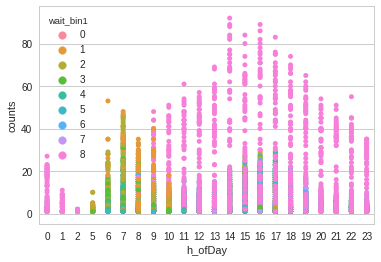

In [32]:
sns.stripplot(x="h_ofDay", y="counts", hue="wait_bin1", data=wait_bin1)

From now on let's cut out the high wait time been it seems to contain experienced data as we assumed.


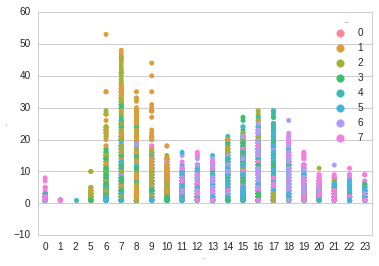

In [137]:
# cut out the last bin from the graphing data 
# set assuming it has artifact data in it
waitbn1= wait_bin1.query("wait_bin1 < 8")[['h_ofDay','wait_bin1', 'counts']]
sns.stripplot(x="h_ofDay", y="counts", hue="wait_bin1", data=waitbn1)

let's now look for bus bunch ups given by short second bus waits

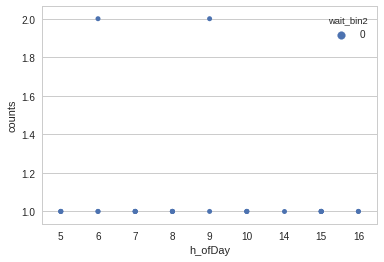

In [31]:
bunchups_bus2= wait_bin2.query("wait_bin2 <= 0")[['h_ofDay','wait_bin2', 'counts']]
sns.stripplot(x="h_ofDay", y="counts", hue="wait_bin2", data=bunchups_bus2)

#red_line.groupby("h_ofDay").wait_bin1.nunique().plot(color="red")
# orange_line.groupby("h_ofDay").trip_id.nunique().plot(color="orange")
# blue_line.groupby("h_ofDay").trip_id.nunique().plot(color="blue")

It may be that bin 1 is really not a bunch ups. Bunch ups may really only occur in bin 0. this is an unexpected result since most of these short wait times happen in the middle of the day though they are also occur during evening rush hour.

let's now take a look at the same thing for third bus bunch ups which ought to be more rare.



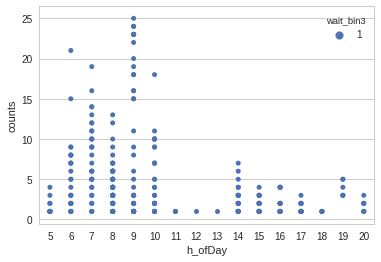

In [32]:
bunchups_bus3= wait_bin3.query("wait_bin3 <= 1")[['h_ofDay','wait_bin3', 'counts']]
sns.stripplot(x="h_ofDay", y="counts", hue="wait_bin3", data=bunchups_bus3)

According to this bus punch ups are most common during lunch time this warrants more investigation.

let's now take a look at how bunch up of events vary with stop sequence, we might think that they get a bit worse as buses travel down the line. This might not necessarily be so if it's highly dependent on time of day. We use a heat map investigate this. 

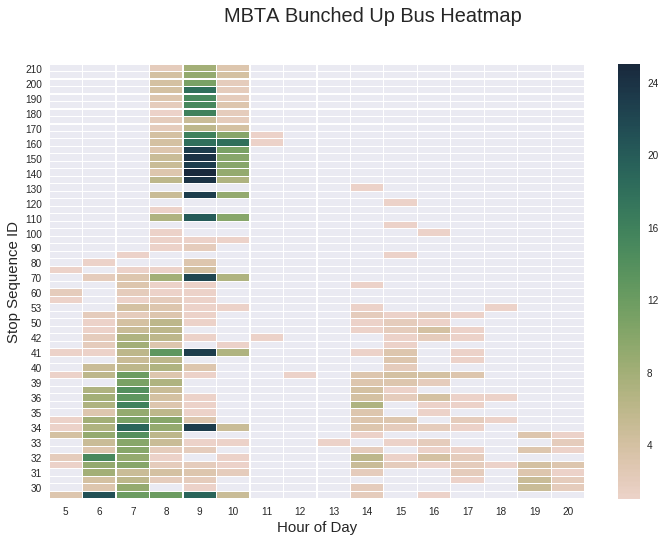

In [37]:
#bunchups_bus3.head(3)
bunchb3_bincut= wait_bin3.query("wait_bin3 <= 1")[['h_ofDay','stop_sequence', 'counts']]

# Lode sns data by reorering the bunchb3_bincut df
bunchb3 = bunchb3_bincut.pivot(index='stop_sequence',columns='h_ofDay',values='counts')

# set grid style
sns.set_style("darkgrid")
# Initialize Figure and Axes object
#plt.figure(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12, 8))
# Setup color palettes
cube1 = sns.cubehelix_palette(12, start=.1, rot=-.79, as_cmap=True)
cube2 = sns.cubehelix_palette(light=.8, as_cmap=True)

# Construct heatmap plot
g = sns.heatmap(bunchb3,  linewidths=.2, cmap = cube1)

# setup graph styles
ymin, ymax = plt.ylim()
plt.ylim(ymax, ymin)
plt.xlim(0, None)
plt.locator_params(axis='y', nbins=30)
ax.set_xlabel('Hour of Day',fontsize=15)
ax.set_ylabel('Stop Sequence ID',fontsize=15)
fig.suptitle('MBTA Bunched Up Bus Heatmap', fontsize=20)


plt.show()
